# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import re
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sadar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sadar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [24]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,Not Verified | \r\nWe traveled to Lisbon for ...
1,✅ Trip Verified | Booked a flight from Buchar...
2,✅ Trip Verified | Booked online months ago an...
3,✅ Trip Verified | The flight was on time. The...
4,"Not Verified | Angry, disappointed, and unsat..."


In [25]:
df.to_csv("data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [41]:
df.loc[16, 'reviews']

"traveled lisbon dream vacation cruise portugal spain friend didn't ever get luggage two week cruise two week without change clothes cpap machine contacting customer service nightmare never talked real person very little effort put getting bag port ship bag airline didn't deliver bag nor friend needed go get couldnt bothered bag ship ba say policy get bag within hour joke two week dont back home u last heard bag lisbon choice don't fly airway customer service non existent"

In [27]:
#all the charaters before "|" symbol is unnecesary as that inculdes "✅ Trip Verified" and "Not Verified"
df['reviews'] = df['reviews'].str.split('|').str[-1]

In [28]:
#converting all text to lower case
df['reviews'] = df['reviews'].str.lower()

In [29]:
#removing special characters (except " ' ") and numbers 
df['reviews'] = df['reviews'].str.replace(r"[^a-zA-Z\s']", '', regex=True)

In [30]:
#custom tokenizer
def custom_tokenizer(text):
    pattern = r"\b\w+(?:'\w+)?\b"
    #create a RegexpTokenizer with the custom pattern
    tokenizer = RegexpTokenizer(pattern)
    tokens = tokenizer.tokenize(text)
    
    return tokens
    

In [31]:
#Custom function for tokeniztaion and keeping words like shouldn't and can't
def process_contraction_tokenization(text):
    #common contractions and their replacements
    contractions = {
        "cannot": "can't",
        "could not": "couldn't",
        "did not": "didn't",
        "does not": "doesn't",
        "do not": "don't",
        "had not": "hadn't",
        "has not": "hasn't",
        "have not": "haven't",
        "is not": "isn't",
        "must not": "mustn't",
        "shall not": "shan't",
        "should not": "shouldn't",
        "were not": "weren't",
        "will not": "won't",
        "would not": "wouldn't",
    }

    #replace contractions with their expanded forms
    for contraction, replacement in contractions.items():
        text = text.replace(contraction, replacement)

    tokens = custom_tokenizer(text)
    
    return tokens

In [33]:
#applying the process_contraction_tokenization function to the 'reviews' column
df['reviews'] = df['reviews'].apply(process_contraction_tokenization)

In [35]:
#creating custom stopword list because some words like "not" and "must" are crucial for sentiment analysis 
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", 
              "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", 
              "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these",
              "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", 
              "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", 
              "of", "at", "by", "for", "with", "about", "between", "into", "through", "during", "before", "after", 
              "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "then", "once",
              "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "more", "some", 
              "such", "own", "same", "so", "than", "too", "will", "now","tell","even",'got','new','take','first',
              'find','given','long','flight','one','people','thing','tried', 'british', 'airway', 'british airway', 
              'london heathrow','london', 'lhr','heathrow', 'gatwick','although','screen','day','via','airline','still',
              'airport','plane','ticket','flight','said','call','airway','airline','check','due']


In [36]:
#function to remove stop words
def remove_stopwords(text):
    #remove stop words
    filtered_words = [word for word in text if word not in stop_words]
    #join the filtered words back into a sentence
    return filtered_words

In [38]:
#applying the remove_stopword function to the 'reviews' column
df['reviews'] = df['reviews'].apply(remove_stopwords)

In [40]:
df.head()

,reviews
0,traveled lisbon dream vacation cruise portugal...
1,booked bucharest manchester h layover delayed ...
2,booked online month ago only hitch replacement...
3,time crew polite story outward ba europe gener...
4,angry disappointed unsatisfied route atlanta s...


In [39]:
#lemmatizing and rejoining the sentence
lemmatizer = WordNetLemmatizer()
df['reviews'] = df['reviews'].apply(lambda x:' '.join([lemmatizer.lemmatize(word) for word in x]))

In [22]:
#removing extra spaces
df['reviews'] = df['reviews'].str.strip()
df['reviews'] = df['reviews'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [18]:
#removing very short words
df['reviews'] = df['reviews'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))

In [19]:
#sample after text cleaning
df.loc[16, 'reviews']

'chaos terminal cancellation delay staff give different reason depending ask answer lie sadly standard worse ever past able use covid excuse short haul club europe trip expect very little barely provide cutback covid permanent can alternative carrier route choose rather sadly route monopoly'

In [20]:
all_words_tokenized = df['reviews'].apply(custom_tokenizer)

In [21]:
#concatenate tokenized words from all reviews into a single list
all_words = [word for review_words in all_words_tokenized for word in review_words]

In [22]:
#create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

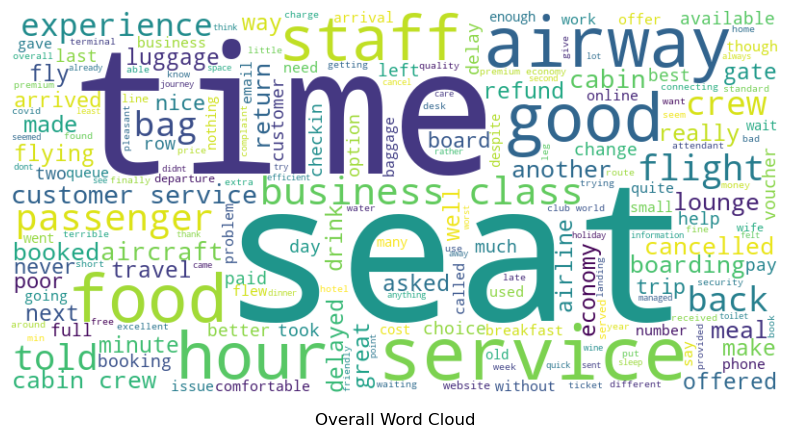

In [23]:
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Overall Word Cloud',y=-0.1)
plt.axis('off')
plt.show()

In [24]:
#using VADER sentiment analyzer to understand the overall sentiments
analyzer = SentimentIntensityAnalyzer()

In [25]:
df['sentiment_scores'] = df['reviews'].apply(analyzer.polarity_scores)

In [26]:
df['sentiment_scores'].apply(lambda x: x.get('compound')).describe()

count    1000.000000
mean        0.105773
std         0.749942
min        -0.992500
25%        -0.680800
50%         0.177900
75%         0.901825
max         0.998200
Name: sentiment_scores, dtype: float64

In [27]:
#function to map the sentiments based on 'compound' score
def map_sentiment(compound_score):
    if compound_score >= 0.5:
        return 'positive'
    elif compound_score <= -0.5:
        return 'negative'
    else:
        return 'neutral'

In [28]:
df['sentiment'] = df['sentiment_scores'].apply(lambda x: map_sentiment(x.get('compound')))

In [29]:
df['sentiment'].describe()

count         1000
unique           3
top       positive
freq           435
Name: sentiment, dtype: object

In [30]:
sentiment_counts = df['sentiment'].value_counts()

In [31]:
sentiment_counts

positive    435
negative    342
neutral     223
Name: sentiment, dtype: int64

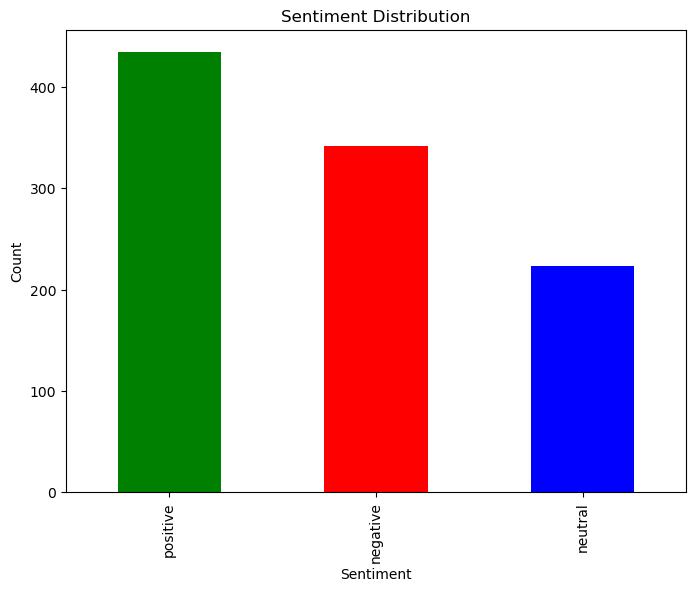

In [32]:
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

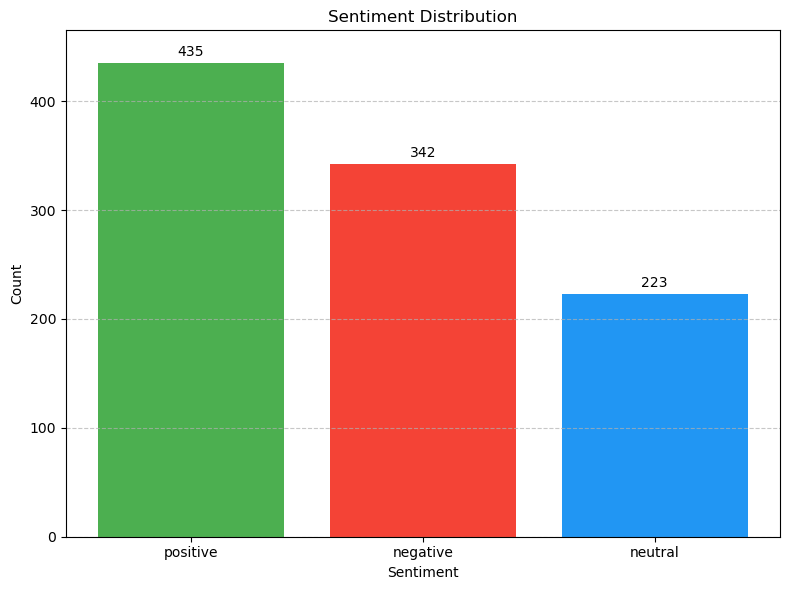

In [34]:
# Create a bar graph with custom styling
plt.figure(figsize=(8, 6))
colors = ['#4CAF50', '#F44336', '#2196F3']  # Custom colors for each sentiment

# Plot the bars
bars = plt.bar(['positive','negative','neutral'], sentiment_counts, color=colors)

# Add data labels above the bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

# Customize the appearance
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.ylim(0, max(sentiment_counts) + 30)  # Adjust the y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.tight_layout()
plt.show()

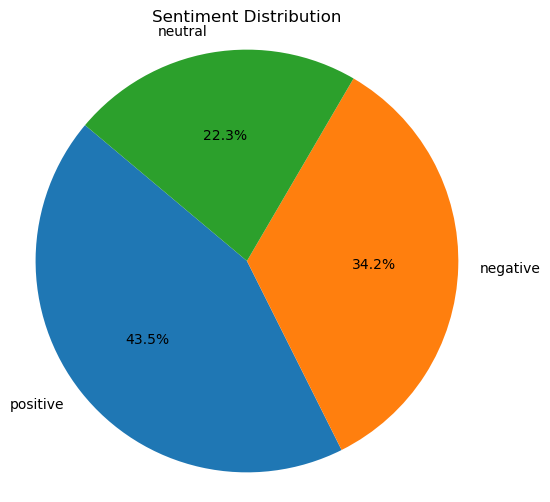

In [35]:
# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')

# Display the chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [36]:
negative_text =df[df['sentiment'] == 'negative']

In [37]:
negative_tokenized = negative_text['reviews'].apply(custom_tokenizer)

#concatenate tokenized words from all reviews into a single list
negative_words = [word for review_words in negative_tokenized for word in review_words]
negative_word_freq = Counter(negative_words)
top_negative_words = dict(negative_word_freq.most_common(50))

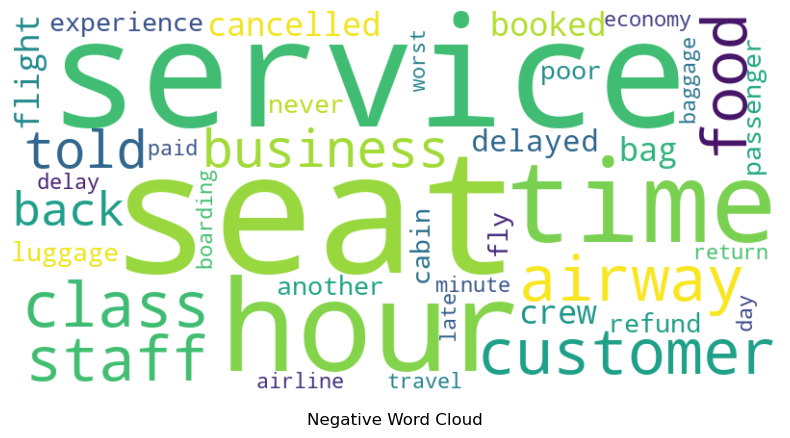

In [38]:
#create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_negative_words))

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Negative Word Cloud',y=-0.1)
plt.axis('off')
plt.show()